<a href="https://colab.research.google.com/github/sagiodev/stable-diffusion-3-api/blob/main/Stable_Diffusion_3_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To get your API key visit https://platform.stability.ai/account/keys

Seed is 54967498
Sending REST request to https://api.stability.ai/v2beta/stable-image/generate/sd3...
Saved image generated_54967498.jpeg


<IPython.core.display.Javascript object>

Result image:


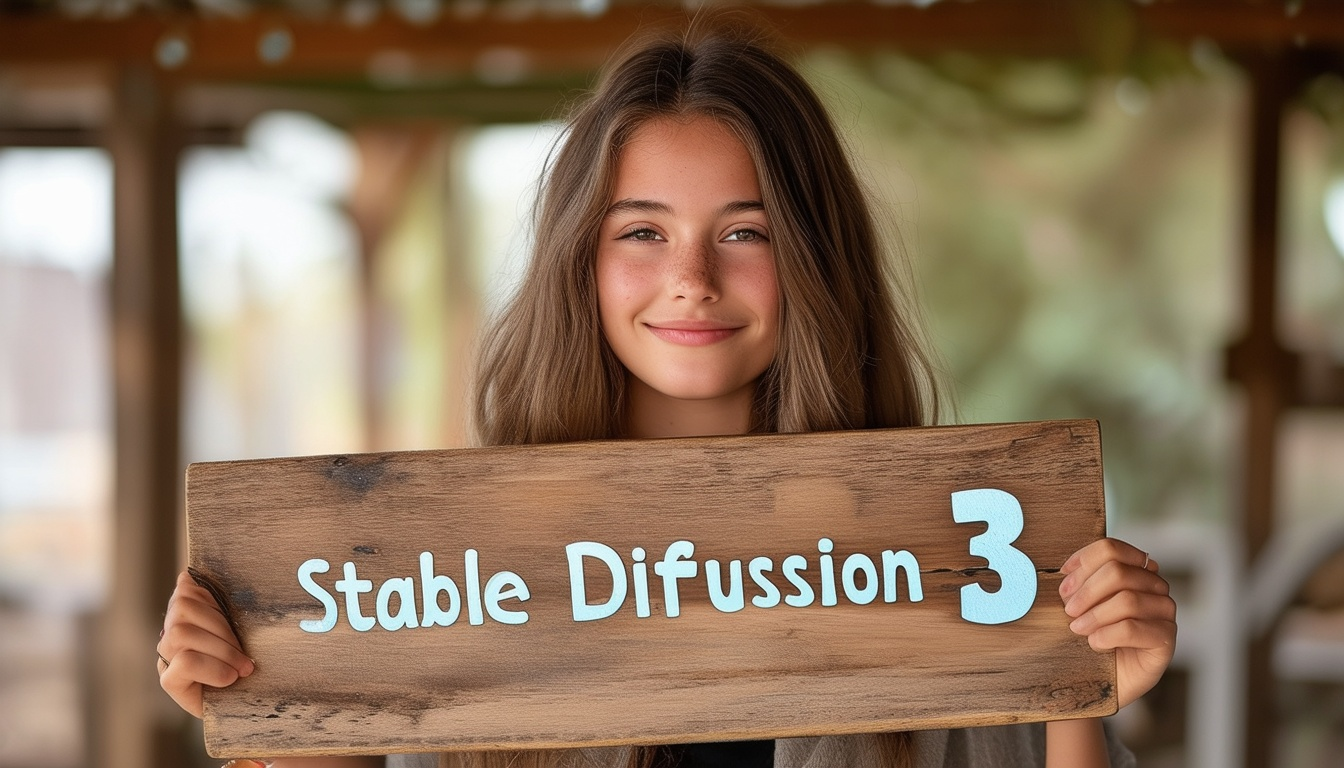

In [5]:
#@title SD3

prompt = "a beautiful girl holding up a wooden sign \"Stable Diffusion 3\"" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
aspect_ratio = "16:9" #@param ["21:9", "16:9", "3:2", "5:4", "1:1", "4:5", "2:3", "9:16", "9:21"]
seed = -1 #@param {type:"integer"}
output_format = "jpeg" #@param ["jpeg", "png"]
model = "sd3" #@param ["sd3", "sd3-turbo"]

host = f"https://api.stability.ai/v2beta/stable-image/generate/sd3"

# allow random seed
import random
if seed == -1:
  seed = random.randint(0,99999999)
  print(f'Seed is {seed}')

params = {
    "prompt" : prompt,
    "negative_prompt" : negative_prompt if model=="sd3" else "",
    "aspect_ratio" : aspect_ratio,
    "seed" : seed,
    "output_format" : output_format,
    "model" : model,
    "mode" : "text-to-image"
}

# get API key
import getpass
if 'STABILITY_KEY' not in locals():
  STABILITY_KEY = getpass.getpass('Enter your API Key')


## Install requirements
from io import BytesIO
import IPython
import json
import os
from PIL import Image
import requests
import time
from google.colab import output

## Define functions

def send_generation_request(
    host,
    params,
):
    headers = {
        "Accept": "image/*",
        "Authorization": f"Bearer {STABILITY_KEY}"
    }

    # Encode parameters
    files = {}
    image = params.pop("image", None)
    mask = params.pop("mask", None)
    if image is not None and image != '':
        files["image"] = open(image, 'rb')
    if mask is not None and mask != '':
        files["mask"] = open(mask, 'rb')
    if len(files)==0:
        files["none"] = ''

    # Send request
    print(f"Sending REST request to {host}...")
    response = requests.post(
        host,
        headers=headers,
        files=files,
        data=params
    )
    if not response.ok:
        raise Exception(f"HTTP {response.status_code}: {response.text}")

    return response

def send_async_generation_request(
    host,
    params,
):
    headers = {
        "Accept": "application/json",
        "Authorization": f"Bearer {STABILITY_KEY}"
    }

    # Encode parameters
    files = {}
    if "init_image" in params:
        init_image = params.pop("init_image")
        files = {"image": open(init_image, 'rb')}

    # Send request
    print(f"Sending REST request to {host}...")
    response = requests.post(
        host,
        headers=headers,
        files=files,
        data=params
    )
    if not response.ok:
        raise Exception(f"HTTP {response.status_code}: {response.text}")

    # Process async response
    response_dict = json.loads(response.text)
    generation_id = response_dict.get("id", None)
    assert generation_id is not None, "Expected id in response"

    # Loop until result or timeout
    timeout = int(os.getenv("WORKER_TIMEOUT", 500))
    start = time.time()
    status_code = 202
    while status_code == 202:
        response = requests.get(
            f"{host}/result/{generation_id}",
            headers={
                **headers,
                "Accept": "image/*"
            },
        )

        if not response.ok:
            raise Exception(f"HTTP {response.status_code}: {response.text}")
        status_code = response.status_code
        time.sleep(10)
        if time.time() - start > timeout:
            raise Exception(f"Timeout after {timeout} seconds")

    return response

# send request
response = send_generation_request(
    host,
    params
)

# Decode response
output_image = response.content
finish_reason = response.headers.get("finish-reason")
seed = response.headers.get("seed")

# Check for NSFW classification
if finish_reason == 'CONTENT_FILTERED':
    raise Warning("Generation failed NSFW classifier")

# Save and display result
generated = f"generated_{seed}.{output_format}"
with open(generated, "wb") as f:
    f.write(output_image)
print(f"Saved image {generated}")

output.no_vertical_scroll()
print("Result image:")
IPython.display.display(Image.open(generated))